## Loading of Miller ECoG data of the joystick track task

includes some visualizations

In [2]:
#@title Data retrieval
import os, requests

fname = 'joystick_track.npz'
url = "https://osf.io/6jncm/download"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)

In [3]:
# @title Install packages (`nilearn`, `nimare`. `duecredit`), import `matplotlib` and set defaults
# install packages to visualize brains and electrode locations
!pip install nilearn --quiet
!pip install nimare --quiet
!pip install duecredit --quiet

from matplotlib import rcParams
from matplotlib import pyplot as plt

rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] = 15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.3/10.3 MB 67.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 107.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 23.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 109.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 112.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.0/81.0 kB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.1/42.1 MB 43.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 341.8/341.8 kB 41.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==1.5.3, but you have pandas 2.0.3 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

In [4]:
# @title Data loading
import numpy as np

alldat = np.load(fname, allow_pickle=True)['dat']

# Select just one of the recordings here. This is subject 1, block 1.
dat = alldat[0][0]

print(dat.keys())

dict_keys(['V', 'targetX', 'targetY', 'cursorX', 'cursorY', 'locs', 'hemisphere', 'lobe', 'gyrus', 'Brodmann_Area'])


# Dataset info #

This is one of multiple ECoG datasets from Miller 2019, recorded in clinical settings with a variety of tasks. Raw data here:

https://exhibits.stanford.edu/data/catalog/zk881ps0522

`dat` contain 4 sessions from 4 subjects, and was used in these papers:

- Schalk, G., et al. "Decoding two-dimensional movement trajectories using electrocorticographic signals in humans." Journal of Neural Engineering 4.3 (2007): 264. doi: [10.1088/1741-2560/4/3/012](https://doi.org/10.1088/1741-2560/4/3/012)

- Schalk, Gerwin, et al. "Two-dimensional movement control using electrocorticographic signals in humans." Journal of Neural Engineering 5.1 (2008): 75. doi: [10.1088/1741-2560/5/1/008](https://doi.org/10.1088/1741-2560/5/1/008)

<br>

From the dataset readme:

*During the study, each patient was in a semi-recumbent position in a hospital bed about 1 m from a computer monitor. The patient used a joystick to maneuver a white cursor track a green target moving counter-clockwise in a circle of diameter 85% of monitor height ~1m away. The hand used to control the joystick was contralateral to the implanted electrode array.*

<br>

We also know that subject 0 was implanted in the left temporal lobe, while subject 2 was implanted in the right frontal lobe.

Sample rate is always 1000Hz, and the ECoG data has been notch-filtered at 60, 120, 180, 240 and 250Hz, followed by z-scoring across the entire recording and conversion to float16 to minimize size.

Variables are:
* `dat['V']`: continuous voltage data (time by channels)
* `dat['targetX']`: position of the target on the screen
* `dat['targetY']`: position of the target on the screen
* `dat['cursorX']`: X position of the cursor controlled by the joystick
* `dat['cursorY']`: X position of the cursor controlled by the joystick
* `dat['locs`]: three-dimensional coordinates of the electrodes

In [5]:
from nilearn import plotting
from nimare import utils

plt.figure(figsize=(8, 8))
locs = dat['locs']
view = plotting.view_markers(utils.tal2mni(locs),
                             marker_labels=['%d'%k for k in np.arange(locs.shape[0])],
                             marker_color='purple',
                             marker_size=5)
view

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# compute correlations between voltage data and X/Y position of cursor
from scipy import signal
dat = alldat[0][3]

V = dat['V'].astype('float32')

nt, nchan = V.shape

targetX = dat['targetX'].flatten()
targetY = dat['targetY'].flatten()

cx = np.zeros(nchan, )
cy = np.zeros(nchan, )
for j in range(nchan):
  cx[j] = np.corrcoef(V[:, j], targetX)[0, 1]
  cy[j] = np.corrcoef(V[:, j], targetY)[0, 1]

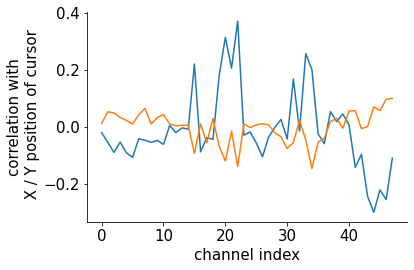

In [ ]:
plt.subplot(1, 4, 1)
plt.plot(cx)
plt.plot(cy)
plt.ylabel('correlation with\n X / Y position of cursor')
plt.xlabel('channel index')
plt.show()

In [ ]:
# this one needs a lot more plots!
# for some reason, I only see meaningful correlations in subjects 2 and 3,
# but it's possible that there is spectral information that is more useful in those subjects

In [46]:
V = dat['V']
score_dummy = V[42,:]

In [47]:
score_dummy.shape

(60,)

In [41]:
type(score_dummy)

numpy.ndarray

In [44]:
def visualization(score, numbering = False):

    """
    Visualize statistical scores or any values associated with electrodes on the brain surface.

    Parameters
    ----------
    score : ndarray
        The statistical scores or any values associated associated with each electrode.
        This should be a 1D array with length equal to the number of electrodes.
    numbering : bool, optional
        If True, the electrodes will be numbered. Default is False.

    Returns
    -------
    nilearn.plotting.html_stat_map.StatMapView
        The brain surface plot with the electrode scores visualized.

    Notes
    -----
    The electrode locations (`locs`) are assumed to be a global variable accessible to the function.
    """

    cmap = plt.cm.get_cmap('viridis')
    colors = cmap(score)

    if numbering == False:
      marker_labels = ['' for _ in locs]
    else:
      marker_labels = ['%d'%k for k in np.arange(locs.shape[0])]

    view = plotting.view_markers(utils.tal2mni(locs),
                              marker_labels=marker_labels,
                              marker_color=colors,
                              marker_size=5)
    return view

In [48]:
visualization(score_dummy)

Output hidden; open in https://colab.research.google.com to view.